<a href="https://colab.research.google.com/github/linhmai19/capstone_project/blob/master/eda_clf_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project

* Student name: Linh Mai
* Student pace: Self Paced
* Scheduled project review date/time: October 6th, 2020 
* Instructor name: Jeff Herman
* Blog post URL:



---



---




# Import dataset

In [97]:
from google.colab import files
uploaded = files.upload()

Saving merge_data.csv to merge_data (1).csv


# Import Libraries

In [98]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
sns.set_style('darkgrid')
import time
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import itertools  
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures

from imblearn.pipeline import make_pipeline, Pipeline

# Import the cleaned merged dataset and review it

In [99]:
df_merge = pd.read_csv('merge_data.csv')
df_merge = df_merge.drop('Unnamed: 0', 1)
df_merge.head()

,publisher,author,isbn,date,title,weeks_on_list,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating,popularity
0,Berkley,Liane Moriarty,0425274861,2017-05-21,BIG LITTLE LIES,38,3,6879,10800,792,736511,1276316,45566,4.27,True
1,Ballantine,Lisa Wingate,0425284697,2018-06-09,BEFORE WE WERE YOURS,35,4,314,515,50,362806,809140,30945,4.37,True
2,Scout,Ruth Ware,1501132954,2017-10-08,THE WOMAN IN CABIN 10,35,5,9381,26152,991,363638,730533,28744,3.70,True
3,Doubleday,John Grisham,1101967684,2017-09-24,THE WHISTLER,25,2,344,711,36,76249,143621,5867,3.85,True
4,Grand Central,Nicholas Sparks,1455520667,2015-05-17,THE LONGEST RIDE,25,3,59,114,23,111329,218143,9818,4.15,True


In [100]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226 entries, 0 to 1225
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   publisher                1226 non-null   object 
 1   author                   1226 non-null   object 
 2   isbn                     1226 non-null   object 
 3   date                     1226 non-null   object 
 4   title                    1226 non-null   object 
 5   weeks_on_list            1226 non-null   int64  
 6   no_of_words_title        1226 non-null   int64  
 7   ratings_count            1226 non-null   int64  
 8   reviews_count            1226 non-null   int64  
 9   text_reviews_count       1226 non-null   int64  
 10  work_ratings_count       1226 non-null   int64  
 11  work_reviews_count       1226 non-null   int64  
 12  work_text_reviews_count  1226 non-null   int64  
 13  average_rating           1226 non-null   float64
 14  popularity              

In [101]:
df_merge.describe()

,weeks_on_list,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating
count,1226.000000,1226.000000,1226.000000,1226.000000,1226.000000,1226.000000,1.226000e+03,1226.000000,1226.000000
mean,1.575041,2.735726,3805.800163,8021.909462,393.761827,47182.860522,8.924791e+04,3620.822186,3.978067
std,3.293729,1.164220,12029.041630,24596.541391,1156.310831,97357.327830,1.693692e+05,6170.101122,0.251391
min,0.000000,1.000000,0.000000,0.000000,0.000000,45.000000,1.770000e+02,2.000000,3.060000
25%,0.000000,2.000000,21.000000,42.000000,5.000000,7146.250000,1.515850e+04,630.750000,3.820000
50%,1.000000,3.000000,82.000000,149.500000,18.000000,16208.000000,3.225650e+04,1421.000000,3.990000
75%,1.000000,3.000000,684.000000,1549.500000,107.000000,41755.750000,8.060425e+04,3530.500000,4.150000
max,38.000000,6.000000,105021.000000,184021.000000,9413.000000,886392.000000,1.477027e+06,47031.000000,4.610000


In [102]:
# Drop weeks_on_list
df_merge = df_merge.drop('weeks_on_list', axis=1)

# Make another dataframe without merging additional features

In [103]:
df_ori = df_merge.drop(columns=['ratings_count','reviews_count','text_reviews_count',
                                'work_ratings_count','work_reviews_count','work_text_reviews_count',
                                'average_rating'], axis=1).copy()

In [104]:
df_ori.head()

,publisher,author,isbn,date,title,no_of_words_title,popularity
0,Berkley,Liane Moriarty,0425274861,2017-05-21,BIG LITTLE LIES,3,True
1,Ballantine,Lisa Wingate,0425284697,2018-06-09,BEFORE WE WERE YOURS,4,True
2,Scout,Ruth Ware,1501132954,2017-10-08,THE WOMAN IN CABIN 10,5,True
3,Doubleday,John Grisham,1101967684,2017-09-24,THE WHISTLER,2,True
4,Grand Central,Nicholas Sparks,1455520667,2015-05-17,THE LONGEST RIDE,3,True


In [105]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226 entries, 0 to 1225
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   publisher          1226 non-null   object
 1   author             1226 non-null   object
 2   isbn               1226 non-null   object
 3   date               1226 non-null   object
 4   title              1226 non-null   object
 5   no_of_words_title  1226 non-null   int64 
 6   popularity         1226 non-null   bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 58.8+ KB


In [106]:
df_ori.describe()

,no_of_words_title
count,1226.000000
mean,2.735726
std,1.164220
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,6.000000


# Visualize the distribution of the target variable

In [107]:
df_merge['popularity'].value_counts(normalize=True)

False    0.91354
True     0.08646
Name: popularity, dtype: float64

False    1120
True      106
Name: popularity, dtype: int64


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

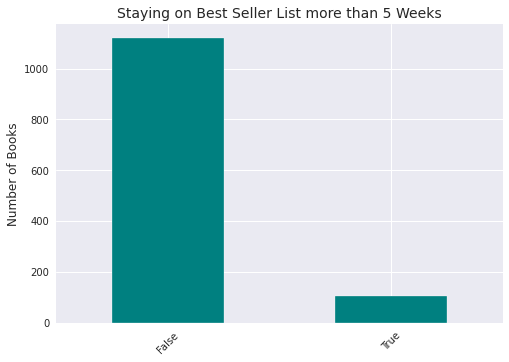

In [108]:
print(df_merge.popularity.value_counts())
df_merge['popularity'].value_counts().plot(kind='bar', color='teal')
plt.title('Staying on Best Seller List more than 5 Weeks', fontsize=14)
plt.ylabel('Number of Books', fontsize=12)
plt.xticks(rotation=45)

# EDA

### Best Sellers Trend by Years

In [146]:
# Change the format of 'date' column
df_merge['date'] = pd.to_datetime(df_merge['date'])
print(df_merge['date'].dtype)

datetime64[ns]


In [147]:
# Extract the year from 'date' column and put it in a new column 'year'
df_merge['year'] = pd.DatetimeIndex(df_merge['date']).year
df_merge.head()

,publisher,author,isbn,date,title,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating,popularity,year
0,Berkley,Liane Moriarty,0425274861,2017-05-21,BIG LITTLE LIES,3,6879,10800,792,736511,1276316,45566,4.27,True,2017
1,Ballantine,Lisa Wingate,0425284697,2018-06-09,BEFORE WE WERE YOURS,4,314,515,50,362806,809140,30945,4.37,True,2018
2,Scout,Ruth Ware,1501132954,2017-10-08,THE WOMAN IN CABIN 10,5,9381,26152,991,363638,730533,28744,3.70,True,2017
3,Doubleday,John Grisham,1101967684,2017-09-24,THE WHISTLER,2,344,711,36,76249,143621,5867,3.85,True,2017
4,Grand Central,Nicholas Sparks,1455520667,2015-05-17,THE LONGEST RIDE,3,59,114,23,111329,218143,9818,4.15,True,2015


In [148]:
yr_list = df_merge['year'].to_list()

In [149]:
# Convert any of the iterable to sequence of iterable years with dintinct years
unique_yrs = set(yr_list)

In [150]:
# Count the number of books for each year
num_yr = {}
for yr in unique_yrs:
    num_yr[yr] = yr_list.count(yr)

In [151]:
# Sort the year list in order of 2011 to 2018
num_yr = dict(sorted(list(num_yr.items())))
num_yr

{2011: 143,
 2012: 137,
 2013: 131,
 2014: 142,
 2015: 174,
 2016: 249,
 2017: 175,
 2018: 75}

In [152]:
# Make 2 lists for years and number of books
yrs = []
counts = []

for yr, count in num_yr.items():
    yrs.append(yr)
    counts.append(count)

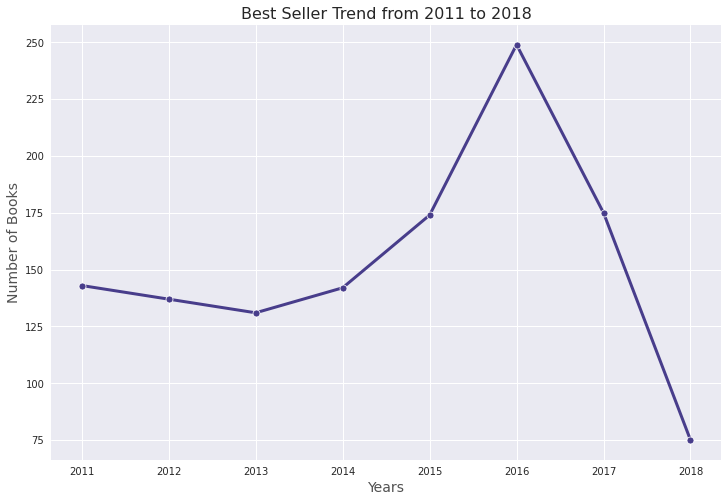

In [153]:
# Graph to see the trend
plt.figure(figsize=(12, 8))
gr3 = sns.lineplot(yrs, counts, ci=None, marker='o', color='darkslateblue', linewidth=3)
gr3.set_ylabel('Number of Books', fontsize=14, alpha=0.8)
gr3.set_xlabel('Years', fontsize=14, alpha=0.8)
gr3.set_title('Best Seller Trend from 2011 to 2018', fontsize=16)
plt.show()

### Top 20 Publishers with the most best selling books

In [109]:
publisher_list = df_merge['publisher'].to_list()

In [110]:
publisher_list

['Berkley',
 'Ballantine',
 'Scout',
 'Doubleday',
 'Grand Central',
 'Doubleday',
 'Dell',
 'Ballantine',
 'Scribner',
 'Vintage',
 'Forge Books',
 "St. Martin's",
 'Ballantine',
 'Grand Central',
 'Harper',
 'Scribner',
 'Grand Central',
 'Grand Central',
 'Delacorte',
 'Doubleday',
 'Grand Central',
 'Riverhead',
 'Sarah Crichton/Farrar, Straus & Giroux',
 'Delacorte Press',
 'Grand Central',
 'Grand Central',
 'Delacorte',
 'Berkley',
 'Grand Central',
 'Little, Brown',
 'Grand Central',
 'Putnam',
 'Knopf',
 'Knopf Doubleday',
 'Vintage',
 'Viking',
 'Flatiron',
 'Grand Central',
 'Delacorte',
 'Grand Central',
 'Grand Central',
 'Little, Brown',
 "St. Martin's",
 'Algonquin',
 'Grand Central',
 'Bantam',
 'Random House',
 'Picador',
 'Scribner',
 'Delacorte',
 'Broadway',
 'Little, Brown & Company',
 'Random House Publishing',
 'Grand Central',
 'Little, Brown',
 'Little, Brown',
 'Little, Brown',
 'Little, Brown',
 'Little, Brown',
 'Scribner',
 'Scribner',
 'Little, Brown',
 'L

In [111]:
# Convert any of the iterable to sequence of iterable publishers with dintinct publishers
unique_publishers = set(publisher_list)

In [112]:
# Count the number of books for each publisher
num_publisher = {}
for publisher in unique_publishers:
    num_publisher[publisher] = publisher_list.count(publisher)
    
num_publisher

{'Ace': 7,
 'Algonquin': 1,
 'Anchor': 3,
 'Atlantic Monthly': 4,
 'Atlantic Monthly Press': 1,
 'Atria': 21,
 'Atria Books': 3,
 'Atria/Emily Bestler': 3,
 'Atria/Keywords': 1,
 'Avon': 29,
 'Avon Impulse': 3,
 'Avon/HarperCollins': 4,
 'Ballantine': 34,
 'Ballatine': 1,
 'Bantam': 25,
 'Berkley': 20,
 'Bethany House': 1,
 'Bloomsbury': 1,
 'BookShots': 6,
 'Broadway': 4,
 'Carina': 1,
 'Carina Press': 1,
 'Center Street': 3,
 'Crown': 1,
 'Crown Archetype': 1,
 'Crown Publishing': 1,
 'Crown/Archetype': 2,
 'Del Rey': 15,
 'Delacorte': 36,
 'Delacorte Press': 1,
 'Dell': 5,
 'Denise Grover Swank': 2,
 'Dial': 3,
 'Doherty': 1,
 'Doubleday': 12,
 'Dutton': 9,
 'Ecco/HarperCollins': 2,
 'Emily Bestler/Atria': 6,
 'Europa Editions': 1,
 'EverAfter Romance': 1,
 'FaithWords': 1,
 'Farrar, Straus & Giroux': 5,
 'Flatiron': 2,
 'Flatiron Books': 1,
 'Forever': 5,
 'Forever/Grand Central': 1,
 'Forge': 1,
 'Forge Books': 1,
 'Gallery': 11,
 'Gallery Books': 9,
 'Grand Central': 60,
 'Grand 

In [113]:
# Sort the publisher list from the highest to the lowest number of books
num_publisher = {k: v for k, v in sorted(num_publisher.items(), key=lambda item: item[1], 
                                         reverse=True)}

In [114]:
# Review the list
num_publisher

{'Ace': 7,
 'Algonquin': 1,
 'Anchor': 3,
 'Atlantic Monthly': 4,
 'Atlantic Monthly Press': 1,
 'Atria': 21,
 'Atria Books': 3,
 'Atria/Emily Bestler': 3,
 'Atria/Keywords': 1,
 'Avon': 29,
 'Avon Impulse': 3,
 'Avon/HarperCollins': 4,
 'Ballantine': 34,
 'Ballatine': 1,
 'Bantam': 25,
 'Berkley': 20,
 'Bethany House': 1,
 'Bloomsbury': 1,
 'BookShots': 6,
 'Broadway': 4,
 'Carina': 1,
 'Carina Press': 1,
 'Center Street': 3,
 'Crown': 1,
 'Crown Archetype': 1,
 'Crown Publishing': 1,
 'Crown/Archetype': 2,
 'Del Rey': 15,
 'Delacorte': 36,
 'Delacorte Press': 1,
 'Dell': 5,
 'Denise Grover Swank': 2,
 'Dial': 3,
 'Doherty': 1,
 'Doubleday': 12,
 'Dutton': 9,
 'Ecco/HarperCollins': 2,
 'Emily Bestler/Atria': 6,
 'Europa Editions': 1,
 'EverAfter Romance': 1,
 'FaithWords': 1,
 'Farrar, Straus & Giroux': 5,
 'Flatiron': 2,
 'Flatiron Books': 1,
 'Forever': 5,
 'Forever/Grand Central': 1,
 'Forge': 1,
 'Forge Books': 1,
 'Gallery': 11,
 'Gallery Books': 9,
 'Grand Central': 60,
 'Grand 

In [115]:
# Make another list with Top 20 publishers with the higest number of best selling books
publisher_20 = dict(itertools.islice(num_publisher.items(), 20))

In [116]:
publisher_20

{'Atria': 21,
 'Avon': 29,
 'Ballantine': 34,
 'Bantam': 25,
 'Berkley': 20,
 'Delacorte': 36,
 'Grand Central': 60,
 'HQN': 20,
 'Harlequin': 38,
 'Harper': 22,
 'HarperCollins': 21,
 'HarperCollins Publishers': 30,
 'Little, Brown': 65,
 'Morrow': 25,
 'Morrow/HarperCollins': 33,
 'Putnam': 46,
 'Random House': 41,
 'Random House Publishing': 40,
 'Simon & Schuster': 67,
 "St. Martin's": 54}

In [117]:
# Make 2 lists for name of publishers and number of books
publishers = []
counts = []

for publisher, count in publisher_20.items():
    publishers.append(publisher)
    counts.append(count)

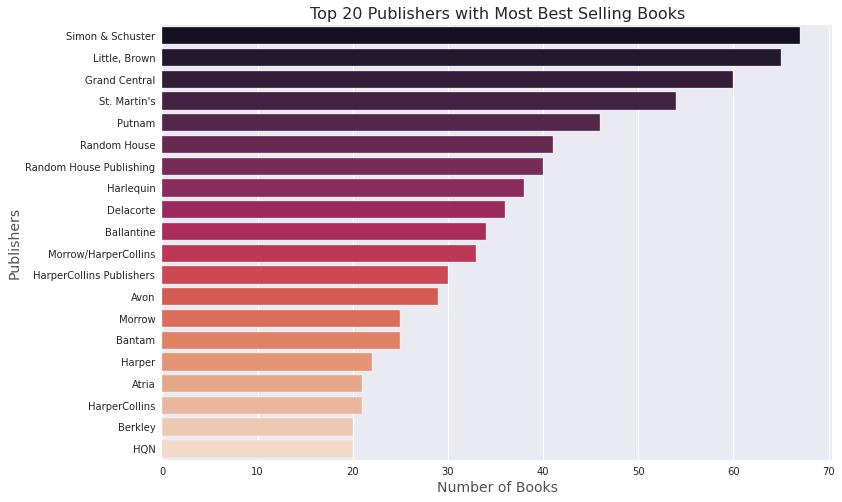

In [118]:
# Graph to see the trend
plt.figure(figsize=(12, 8))
gr1 = sns.barplot(x=counts, y=publishers,
                  ci=None, palette='rocket')
gr1.set_xlabel('Number of Books', fontsize=14, alpha=0.8)
gr1.set_ylabel('Publishers', fontsize=14, alpha=0.8)
gr1.set_title('Top 20 Publishers with Most Best Selling Books', fontsize=16)
plt.show()

### Top 20 Authors with the most best selling books

In [119]:
author_list = df_merge['author'].to_list()

In [120]:
# Convert any of the iterable to sequence of iterable authors with dintinct authors
unique_authors = set(author_list)

In [121]:
# Count the number of books for each author
num_author = {}
for author in unique_authors:
    num_author[author] = author_list.count(author)
    
num_author

{'A L Jackson': 1,
 'Aaron Allston': 1,
 'Abbi Glines': 5,
 'Abraham Verghese': 1,
 'Ace Atkins': 1,
 'Adriana Trigiani': 3,
 'Aimee Molloy': 1,
 'Alan Bradley': 2,
 'Alan Dean Foster': 1,
 'Alan Furst': 3,
 'Aleatha Romig': 1,
 'Alessandra Torre': 1,
 'Alexander McCall Smith': 3,
 'Alice Hoffman': 4,
 'Allison Brennan': 3,
 'Amanda Quick': 2,
 'Amy Tan': 1,
 'Anita Shreve': 1,
 'Ann Brashares': 1,
 'Ann Patchett': 3,
 'Anna Quindlen': 2,
 'Anne Bishop': 2,
 'Anne Hillerman': 3,
 'Anne Rice': 2,
 'Anne Rivers Siddons': 1,
 'Anne Tyler': 1,
 'Annie Barrows': 1,
 'Annie Proulx': 1,
 'Anthony Ryan': 1,
 'Ayana Mathis': 1,
 'B A Paris': 1,
 'Barbara Delinsky': 1,
 'Barbara Kingsolver': 1,
 'Bernard Cornwell': 5,
 'Beth Kerry': 1,
 'Beverly Lewis': 1,
 'Blake Crouch': 1,
 'Brad Meltzer': 2,
 'Brad Meltzer and Tod Goldberg': 1,
 'Brad Taylor': 1,
 'Brad Thor': 5,
 'Brandon Sanderson': 4,
 'Brent Weeks': 2,
 'Bryan Reardon': 1,
 'C J Box': 3,
 'CJ Box': 1,
 'Carl Hiaasen': 1,
 'Catherine Ande

In [122]:
# Sort the author list from the highest to the lowest number of books
num_author = {k: v for k, v in sorted(num_author.items(), key=lambda item: item[1], 
                                         reverse=True)}

In [123]:
# Review the list
num_author

{'A L Jackson': 1,
 'Aaron Allston': 1,
 'Abbi Glines': 5,
 'Abraham Verghese': 1,
 'Ace Atkins': 1,
 'Adriana Trigiani': 3,
 'Aimee Molloy': 1,
 'Alan Bradley': 2,
 'Alan Dean Foster': 1,
 'Alan Furst': 3,
 'Aleatha Romig': 1,
 'Alessandra Torre': 1,
 'Alexander McCall Smith': 3,
 'Alice Hoffman': 4,
 'Allison Brennan': 3,
 'Amanda Quick': 2,
 'Amy Tan': 1,
 'Anita Shreve': 1,
 'Ann Brashares': 1,
 'Ann Patchett': 3,
 'Anna Quindlen': 2,
 'Anne Bishop': 2,
 'Anne Hillerman': 3,
 'Anne Rice': 2,
 'Anne Rivers Siddons': 1,
 'Anne Tyler': 1,
 'Annie Barrows': 1,
 'Annie Proulx': 1,
 'Anthony Ryan': 1,
 'Ayana Mathis': 1,
 'B A Paris': 1,
 'Barbara Delinsky': 1,
 'Barbara Kingsolver': 1,
 'Bernard Cornwell': 5,
 'Beth Kerry': 1,
 'Beverly Lewis': 1,
 'Blake Crouch': 1,
 'Brad Meltzer': 2,
 'Brad Meltzer and Tod Goldberg': 1,
 'Brad Taylor': 1,
 'Brad Thor': 5,
 'Brandon Sanderson': 4,
 'Brent Weeks': 2,
 'Bryan Reardon': 1,
 'C J Box': 3,
 'CJ Box': 1,
 'Carl Hiaasen': 1,
 'Catherine Ande

In [124]:
# Make another list with Top 20 authors with the higest number of best selling books
author_20 = dict(itertools.islice(num_author.items(), 20))

In [125]:
author_20

{'Danielle Steel': 25,
 'David Baldacci': 18,
 'Debbie Macomber': 12,
 'Douglas Preston and Lincoln Child': 10,
 'Iris Johansen': 11,
 'J A Jance': 13,
 'James Patterson and Maxine Paetro': 11,
 'Janet Evanovich': 13,
 'Jill Shalvis': 10,
 'John Grisham': 11,
 'Karen Kingsbury': 11,
 'Lee Child': 12,
 'Linda Lael Miller': 11,
 'Lisa Scottoline': 11,
 'Michael Connelly': 12,
 'Nora Roberts': 12,
 'Ron Carr': 17,
 'Sandra Brown': 10,
 'Stephen King': 11,
 'Susan Mallery': 20}

In [126]:
# Make 2 lists for name of publishers and number of books
authors = []
counts = []

for author, count in author_20.items():
    authors.append(author)
    counts.append(count)

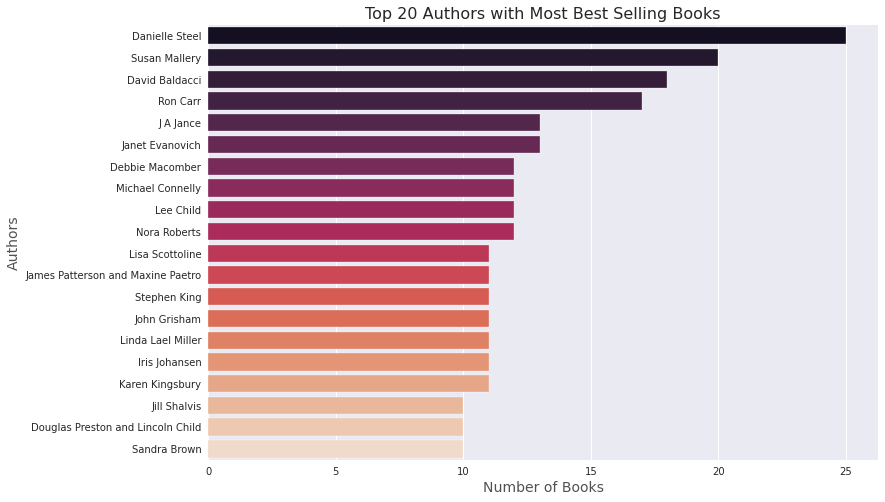

In [127]:
# Graph to see the trend
plt.figure(figsize=(12, 8))
gr2 = sns.barplot(x=counts, y=authors,
                  ci=None, palette='rocket')
gr2.set_xlabel('Number of Books', fontsize=14, alpha=0.8)
gr2.set_ylabel('Authors', fontsize=14, alpha=0.8)
gr2.set_title('Top 20 Authors with Most Best Selling Books', fontsize=16)
plt.show()

### Most Rated Books

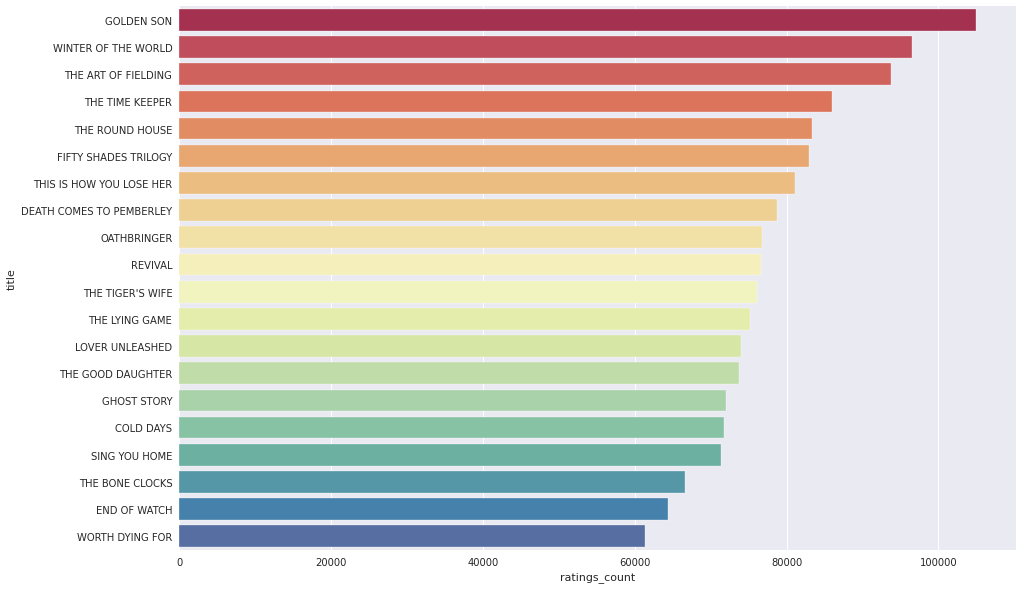

In [139]:
most_rated = df_merge.sort_values('ratings_count', ascending = False).head(20).set_index('title')
plt.figure(figsize=(15,10))
sns.barplot(most_rated['ratings_count'], most_rated.index, palette='Spectral')

### Relationship between Number of Words in the Title with Reviews Count, alongwith the Book Titles

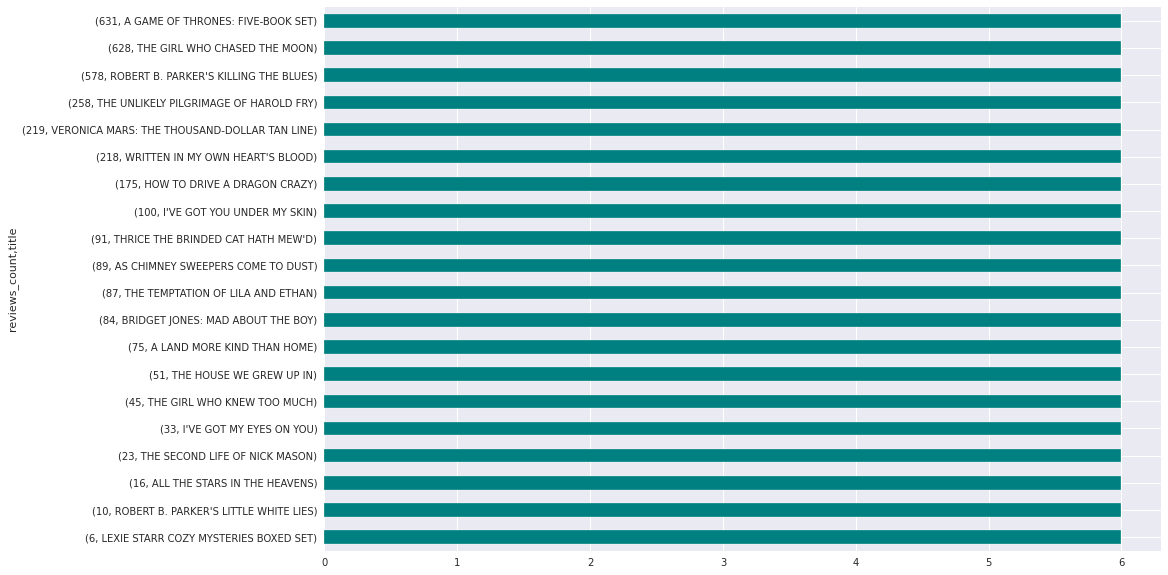

In [145]:
plt.figure(figsize=(15,10))
df_merge.groupby(['reviews_count','title']).no_of_words_title.sum().nlargest(20).plot(kind='barh',color='teal')

The top 20 books with most review counts all have 6 words in the title. 

In [154]:
df_merge = df_merge.drop('year', axis=1)

# Correlation between Variables

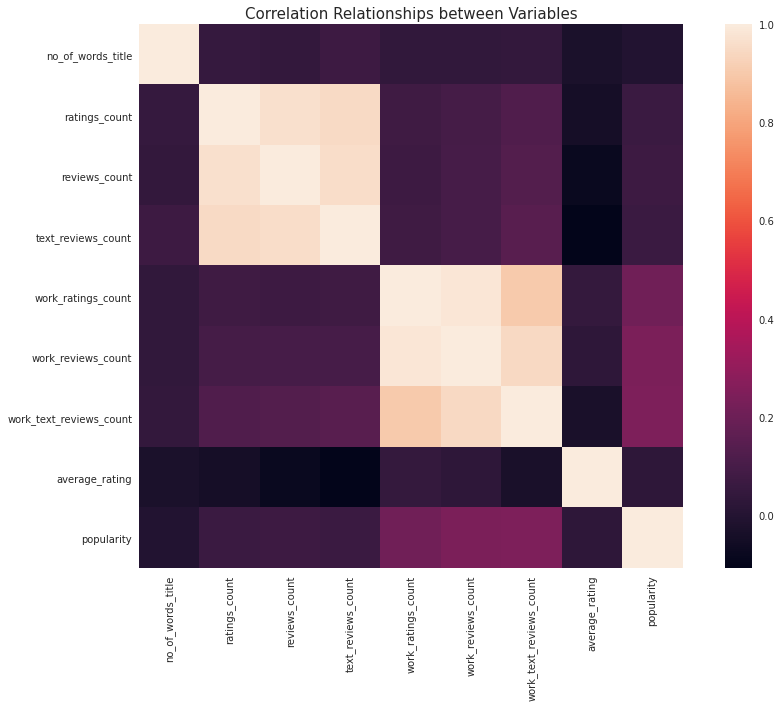

In [155]:
corr = df_merge.corr()
f, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr, vmax=1., square=True)
plt.title('Correlation Relationships between Variables', fontsize=15)
plt.show()

# Deal with Categorical features

### Dummy Variables

The categorical features in this dataset are not ordinal. In addition, the numbers of categories in these features are quite large. Therefore, we cannot use Label Encoding and One Hot Encoding as these two methods require that the categorical feature is ordinal (Label Encoding) and the number of categories is small (One Hot Encoding).

In [156]:
# Categorical features
cat_feats = ['publisher', 'author']

In [157]:
# Get dummies variables for 'publisher' and 'author' in the merged dataframe
df_merge = pd.concat([df_merge, pd.get_dummies(df_merge['publisher'], prefix='dummy')], axis=1)
df_merge = pd.concat([df_merge, pd.get_dummies(df_merge['author'], prefix='dummy')], axis=1)
df_merge.drop(['publisher', 'author'], axis=1, inplace=True)
df_merge.head()

,isbn,date,title,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating,popularity,dummy_Ace,dummy_Algonquin,dummy_Anchor,dummy_Atlantic Monthly,dummy_Atlantic Monthly Press,dummy_Atria,dummy_Atria Books,dummy_Atria/Emily Bestler,dummy_Atria/Keywords,dummy_Avon,dummy_Avon Impulse,dummy_Avon/HarperCollins,dummy_Ballantine,dummy_Ballatine,dummy_Bantam,dummy_Berkley,dummy_Bethany House,dummy_Bloomsbury,dummy_BookShots,dummy_Broadway,dummy_Carina,dummy_Carina Press,dummy_Center Street,dummy_Crown,dummy_Crown Archetype,dummy_Crown Publishing,dummy_Crown/Archetype,dummy_Del Rey,...,dummy_Susan Wiggs,dummy_Susan Wilson,dummy_Susanna Kearsley,dummy_Suzanne Brockmann,dummy_Sylvia Day,dummy_Tami Hoag,dummy_Tara Conklin,dummy_Tatiana de Rosnay,dummy_Tayari Jones,dummy_Taylor Stevens,dummy_Tea Obreht,dummy_Ted Bell,dummy_Ted Dekker,dummy_Terry Brooks,dummy_Terry Goodkind,dummy_Terry McMillan,dummy_Terry Pratchett,dummy_Tess Gerritsen,dummy_Tessa Dare,dummy_Thomas Pynchon,dummy_Timothy Zahn,dummy_Tina Reber,dummy_Tom Hanks,dummy_Tom Wolfe,dummy_Toni Morrison,dummy_Tracy Wolff,dummy_Troy Denning,dummy_Umberto Eco,dummy_VC Andrews,dummy_Vince Flynn,dummy_Vince Flynn and Kyle Mills,dummy_W Bruce Cameron,dummy_Wiley Cash,dummy_William Kent Krueger,dummy_William Landay,dummy_William R Forstchen,dummy_Wm Paul Young,dummy_Zadie Smith,dummy_Zane,dummy_ï»¿Imbolo Mbue
0,0425274861,2017-05-21,BIG LITTLE LIES,3,6879,10800,792,736511,1276316,45566,4.27,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0425284697,2018-06-09,BEFORE WE WERE YOURS,4,314,515,50,362806,809140,30945,4.37,True,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1501132954,2017-10-08,THE WOMAN IN CABIN 10,5,9381,26152,991,363638,730533,28744,3.70,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1101967684,2017-09-24,THE WHISTLER,2,344,711,36,76249,143621,5867,3.85,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1455520667,2015-05-17,THE LONGEST RIDE,3,59,114,23,111329,218143,9818,4.15,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [158]:
# Get dummies variables for 'publisher' and 'author' in the original dataframe (non-merged)
df_ori = pd.concat([df_ori, pd.get_dummies(df_ori['publisher'], prefix='dummy')], axis=1)
df_ori = pd.concat([df_ori, pd.get_dummies(df_ori['author'], prefix='dummy')], axis=1)
df_ori.drop(['publisher', 'author'], axis=1, inplace=True)
df_ori.head()

,isbn,date,title,no_of_words_title,popularity,dummy_Ace,dummy_Algonquin,dummy_Anchor,dummy_Atlantic Monthly,dummy_Atlantic Monthly Press,dummy_Atria,dummy_Atria Books,dummy_Atria/Emily Bestler,dummy_Atria/Keywords,dummy_Avon,dummy_Avon Impulse,dummy_Avon/HarperCollins,dummy_Ballantine,dummy_Ballatine,dummy_Bantam,dummy_Berkley,dummy_Bethany House,dummy_Bloomsbury,dummy_BookShots,dummy_Broadway,dummy_Carina,dummy_Carina Press,dummy_Center Street,dummy_Crown,dummy_Crown Archetype,dummy_Crown Publishing,dummy_Crown/Archetype,dummy_Del Rey,dummy_Delacorte,dummy_Delacorte Press,dummy_Dell,dummy_Denise Grover Swank,dummy_Dial,dummy_Doherty,dummy_Doubleday,...,dummy_Susan Wiggs,dummy_Susan Wilson,dummy_Susanna Kearsley,dummy_Suzanne Brockmann,dummy_Sylvia Day,dummy_Tami Hoag,dummy_Tara Conklin,dummy_Tatiana de Rosnay,dummy_Tayari Jones,dummy_Taylor Stevens,dummy_Tea Obreht,dummy_Ted Bell,dummy_Ted Dekker,dummy_Terry Brooks,dummy_Terry Goodkind,dummy_Terry McMillan,dummy_Terry Pratchett,dummy_Tess Gerritsen,dummy_Tessa Dare,dummy_Thomas Pynchon,dummy_Timothy Zahn,dummy_Tina Reber,dummy_Tom Hanks,dummy_Tom Wolfe,dummy_Toni Morrison,dummy_Tracy Wolff,dummy_Troy Denning,dummy_Umberto Eco,dummy_VC Andrews,dummy_Vince Flynn,dummy_Vince Flynn and Kyle Mills,dummy_W Bruce Cameron,dummy_Wiley Cash,dummy_William Kent Krueger,dummy_William Landay,dummy_William R Forstchen,dummy_Wm Paul Young,dummy_Zadie Smith,dummy_Zane,dummy_ï»¿Imbolo Mbue
0,0425274861,2017-05-21,BIG LITTLE LIES,3,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0425284697,2018-06-09,BEFORE WE WERE YOURS,4,True,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1501132954,2017-10-08,THE WOMAN IN CABIN 10,5,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1101967684,2017-09-24,THE WHISTLER,2,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1455520667,2015-05-17,THE LONGEST RIDE,3,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Deal with Continuous Features 

* Standardization maintains outliers whereas normalization makes outliers less obvious. In applications where outliers are useful, standardization should be done.
* StandardScaler() will transform each value in the column to range about the mean 0 and standard deviation 1, ie, each value will be normalised by subtracting the mean and dividing by standard deviation. Use StandardScaler if you know the data distribution is normal.

In [159]:
con_feats = ['no_of_words_title','ratings_count','reviews_count','text_reviews_count',
             'work_ratings_count','work_reviews_count','work_text_reviews_count','average_rating']

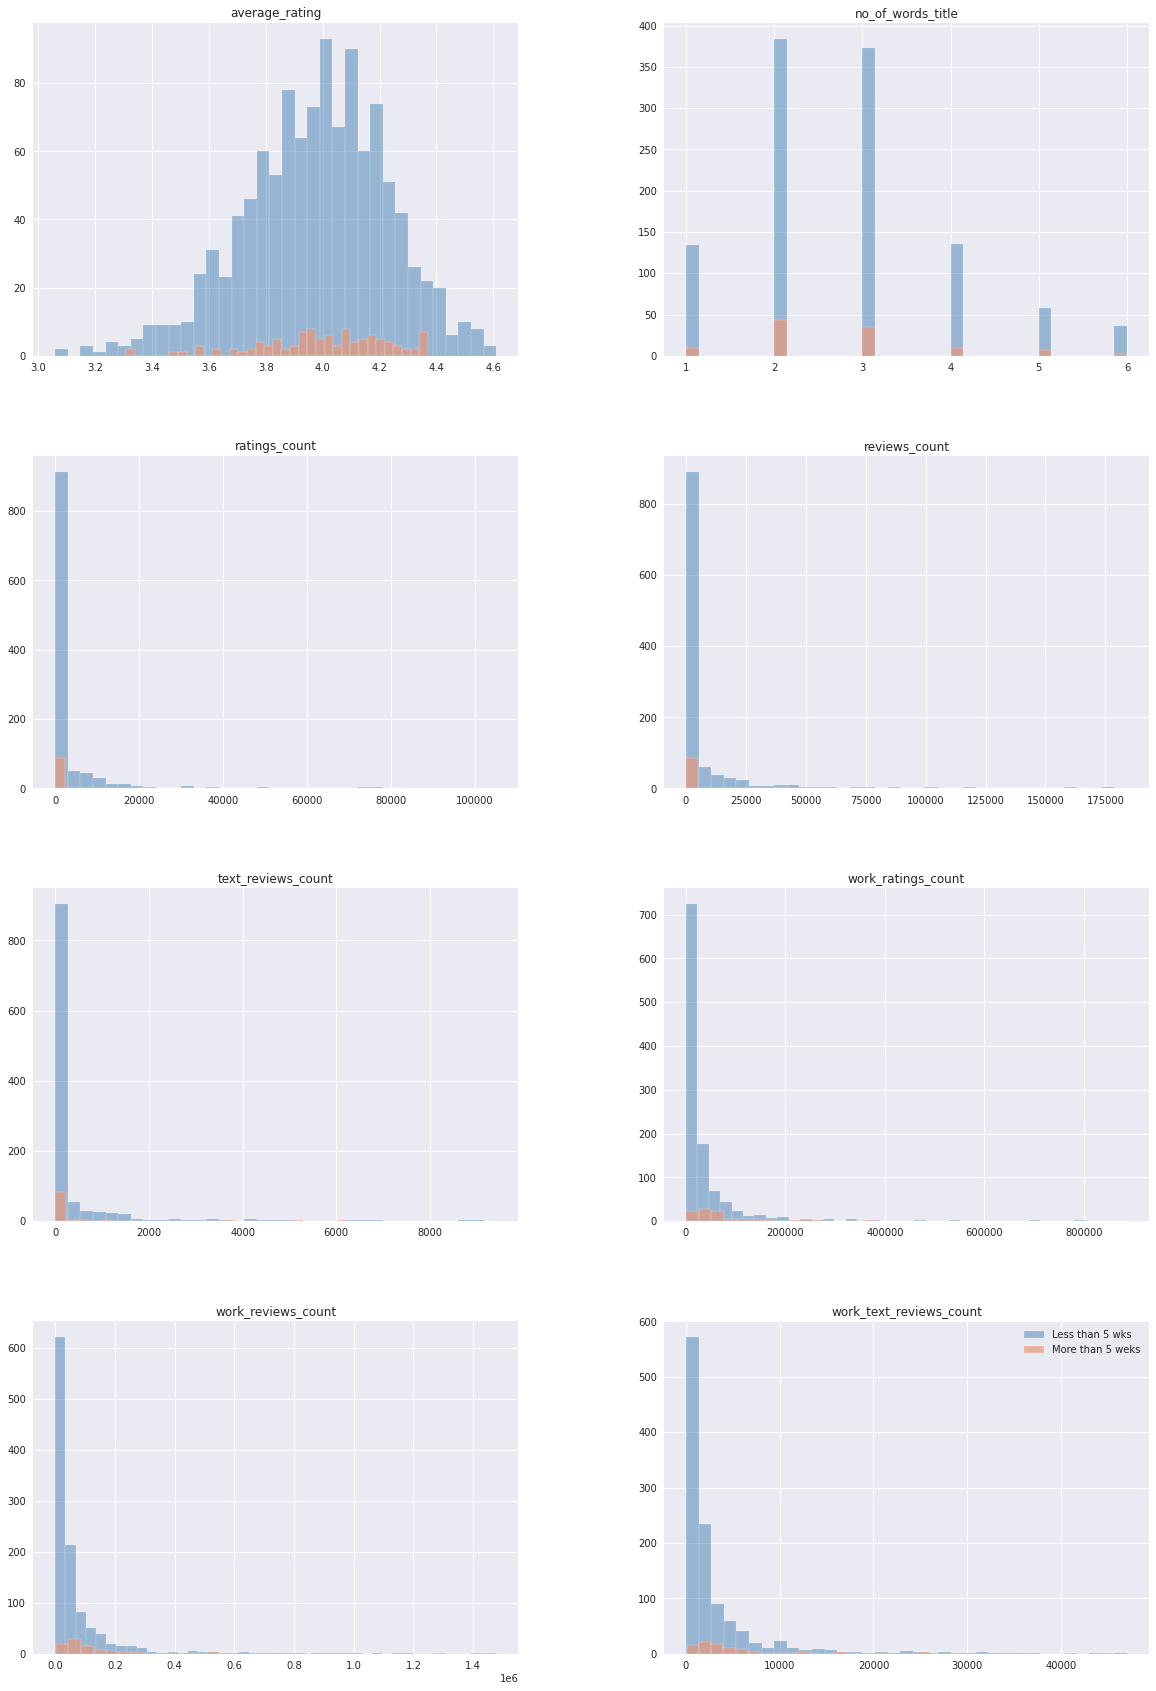

In [160]:
fig, ax = plt.subplots(4, 2, figsize=(20, 30))
df_merge[df_merge.popularity == False][con_feats].hist(bins=35, color="steelblue", alpha=0.5, ax=ax)
df_merge[df_merge.popularity == True][con_feats].hist(bins=35, color="darksalmon", alpha=0.7, ax=ax)
plt.legend(['Less than 5 wks', 'More than 5 weks'])

#### Scale the continuous data with StandardScaler

For the merged dataframe

In [161]:
ss = StandardScaler()
scaled = ss.fit_transform(df_merge[con_feats])
scaled = pd.DataFrame(scaled, columns=con_feats)

In [162]:
# Drop the original values and merge the scaled values for continuous columns
df1 = df_merge.drop(columns=con_feats, axis = 1)
df1 = df1.merge(scaled, left_index=True, right_index=True, how = "left")
df1.head()

,isbn,date,title,popularity,dummy_Ace,dummy_Algonquin,dummy_Anchor,dummy_Atlantic Monthly,dummy_Atlantic Monthly Press,dummy_Atria,dummy_Atria Books,dummy_Atria/Emily Bestler,dummy_Atria/Keywords,dummy_Avon,dummy_Avon Impulse,dummy_Avon/HarperCollins,dummy_Ballantine,dummy_Ballatine,dummy_Bantam,dummy_Berkley,dummy_Bethany House,dummy_Bloomsbury,dummy_BookShots,dummy_Broadway,dummy_Carina,dummy_Carina Press,dummy_Center Street,dummy_Crown,dummy_Crown Archetype,dummy_Crown Publishing,dummy_Crown/Archetype,dummy_Del Rey,dummy_Delacorte,dummy_Delacorte Press,dummy_Dell,dummy_Denise Grover Swank,dummy_Dial,dummy_Doherty,dummy_Doubleday,dummy_Dutton,...,dummy_Tayari Jones,dummy_Taylor Stevens,dummy_Tea Obreht,dummy_Ted Bell,dummy_Ted Dekker,dummy_Terry Brooks,dummy_Terry Goodkind,dummy_Terry McMillan,dummy_Terry Pratchett,dummy_Tess Gerritsen,dummy_Tessa Dare,dummy_Thomas Pynchon,dummy_Timothy Zahn,dummy_Tina Reber,dummy_Tom Hanks,dummy_Tom Wolfe,dummy_Toni Morrison,dummy_Tracy Wolff,dummy_Troy Denning,dummy_Umberto Eco,dummy_VC Andrews,dummy_Vince Flynn,dummy_Vince Flynn and Kyle Mills,dummy_W Bruce Cameron,dummy_Wiley Cash,dummy_William Kent Krueger,dummy_William Landay,dummy_William R Forstchen,dummy_Wm Paul Young,dummy_Zadie Smith,dummy_Zane,dummy_ï»¿Imbolo Mbue,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating
0,0425274861,2017-05-21,BIG LITTLE LIES,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.227089,0.255586,0.112992,0.344545,7.083282,7.011622,6.800909,1.161746
1,0425284697,2018-06-09,BEFORE WE WERE YOURS,True,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.086384,-0.290399,-0.305326,-0.297413,3.243227,4.252167,4.430289,1.559695
2,1501132954,2017-10-08,THE WOMAN IN CABIN 10,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.945679,0.463667,0.737400,0.516714,3.251777,3.787861,4.073423,-1.106566
3,1101967684,2017-09-24,THE WHISTLER,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.632205,-0.287904,-0.297355,-0.309526,0.298673,0.321164,0.364191,-0.509641
4,1455520667,2015-05-17,THE LONGEST RIDE,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.227089,-0.311607,-0.321636,-0.320773,0.659142,0.761341,1.004798,0.684207


For the original dataframe

In [163]:
con_feat_ori = ['no_of_words_title']

In [164]:
scaled_2 = ss.fit_transform(df_ori[con_feat_ori])
scaled_2 = pd.DataFrame(scaled_2, columns=con_feat_ori)

In [165]:
# Drop the original values and merge the scaled values for continuous columns
df2 = df_ori.drop(columns=con_feat_ori, axis = 1)
df2 = df2.merge(scaled_2, left_index=True, right_index=True, how = "left")
df2.head()

,isbn,date,title,popularity,dummy_Ace,dummy_Algonquin,dummy_Anchor,dummy_Atlantic Monthly,dummy_Atlantic Monthly Press,dummy_Atria,dummy_Atria Books,dummy_Atria/Emily Bestler,dummy_Atria/Keywords,dummy_Avon,dummy_Avon Impulse,dummy_Avon/HarperCollins,dummy_Ballantine,dummy_Ballatine,dummy_Bantam,dummy_Berkley,dummy_Bethany House,dummy_Bloomsbury,dummy_BookShots,dummy_Broadway,dummy_Carina,dummy_Carina Press,dummy_Center Street,dummy_Crown,dummy_Crown Archetype,dummy_Crown Publishing,dummy_Crown/Archetype,dummy_Del Rey,dummy_Delacorte,dummy_Delacorte Press,dummy_Dell,dummy_Denise Grover Swank,dummy_Dial,dummy_Doherty,dummy_Doubleday,dummy_Dutton,...,dummy_Susan Wilson,dummy_Susanna Kearsley,dummy_Suzanne Brockmann,dummy_Sylvia Day,dummy_Tami Hoag,dummy_Tara Conklin,dummy_Tatiana de Rosnay,dummy_Tayari Jones,dummy_Taylor Stevens,dummy_Tea Obreht,dummy_Ted Bell,dummy_Ted Dekker,dummy_Terry Brooks,dummy_Terry Goodkind,dummy_Terry McMillan,dummy_Terry Pratchett,dummy_Tess Gerritsen,dummy_Tessa Dare,dummy_Thomas Pynchon,dummy_Timothy Zahn,dummy_Tina Reber,dummy_Tom Hanks,dummy_Tom Wolfe,dummy_Toni Morrison,dummy_Tracy Wolff,dummy_Troy Denning,dummy_Umberto Eco,dummy_VC Andrews,dummy_Vince Flynn,dummy_Vince Flynn and Kyle Mills,dummy_W Bruce Cameron,dummy_Wiley Cash,dummy_William Kent Krueger,dummy_William Landay,dummy_William R Forstchen,dummy_Wm Paul Young,dummy_Zadie Smith,dummy_Zane,dummy_ï»¿Imbolo Mbue,no_of_words_title
0,0425274861,2017-05-21,BIG LITTLE LIES,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.227089
1,0425284697,2018-06-09,BEFORE WE WERE YOURS,True,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.086384
2,1501132954,2017-10-08,THE WOMAN IN CABIN 10,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.945679
3,1101967684,2017-09-24,THE WHISTLER,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.632205
4,1455520667,2015-05-17,THE LONGEST RIDE,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.227089


# Drop unnecessary columns for modeling

In [166]:
df1 = df1.drop(columns=['isbn','date','title'], axis=1).copy()
df2 = df2.drop(columns=['isbn','date','title'], axis=1).copy()

# Deal with Duplicated Columns in the Datasets

In [167]:
# Check for duplicated columns
duplicate_columns = df1.columns[df1.columns.duplicated()]
duplicate_columns

Index(['dummy_Denise Grover Swank', 'dummy_Ilona Andrews',
       'dummy_Kathleen Brooks', 'dummy_Laurelin Paige', 'dummy_Liliana Hart'],
      dtype='object')

Because both df1 and df2 have the same dummy variables for authors, they have the same duplicated columns. We will check to see if these columns are identical. If yes, one will be removed in a pair of duplicates

In [168]:
# Rename the duplicated columns
cols=pd.Series(df1.columns)
for dup in df1.columns[df1.columns.duplicated(keep=False)]: 
    cols[df1.columns.get_loc(dup)] = ([dup + '_' + str(d_idx) 
                                     if d_idx != 0 
                                     else dup 
                                     for d_idx in range(df1.columns.get_loc(dup).sum())])

df1.columns=cols

In [169]:
# Check for duplicated columns again
duplicate_columns = df1.columns[df1.columns.duplicated()]
duplicate_columns

Index([], dtype='object')

We need to check to see whether these duplicated columns are identical

In [170]:
df1['dummy_Denise Grover Swank'].equals(df1['dummy_Denise Grover Swank_1'])

True

In [171]:
df1['dummy_Ilona Andrews'].equals(df1['dummy_Ilona Andrews_1'])

False

In [172]:
df1['dummy_Kathleen Brooks'].equals(df1['dummy_Kathleen Brooks_1'])

True

In [173]:
df1['dummy_Laurelin Paige'].equals(df1['dummy_Laurelin Paige_1'])

True

In [174]:
df1['dummy_Liliana Hart'].equals(df1['dummy_Liliana Hart_1'])

True

Only dummy variable columns of author Ilona Andrews are not identical. Therefore, we will drop the duplicates in others

In [175]:
df1 = df1.drop(columns=['dummy_Denise Grover Swank_1','dummy_Kathleen Brooks_1',
                        'dummy_Laurelin Paige_1','dummy_Liliana Hart_1'], axis=1).copy()

Do the similar steps for df2

In [176]:
# Rename the duplicated columns
cols=pd.Series(df2.columns)
for dup in df2.columns[df2.columns.duplicated(keep=False)]: 
    cols[df2.columns.get_loc(dup)] = ([dup + '_' + str(d_idx) 
                                     if d_idx != 0 
                                     else dup 
                                     for d_idx in range(df2.columns.get_loc(dup).sum())])

df2.columns=cols

In [177]:
# Check for duplicated columns again
duplicate_columns = df2.columns[df2.columns.duplicated()]
duplicate_columns

Index([], dtype='object')

In [178]:
# Remove the duplicated columns
df2 = df2.drop(columns=['dummy_Denise Grover Swank_1','dummy_Kathleen Brooks_1',
                        'dummy_Laurelin Paige_1','dummy_Liliana Hart_1'], axis=1).copy()

# Modeling for Merged Dataset

## Statsmodel's Ordinary Least Squares (OLS)

In [179]:
# Define features X and target y
y = df1['popularity']
X = df1.drop('popularity', axis=1)

# Define the intercept
X = sm.add_constant(X)

# Fit a model
model = sm.OLS(y, X)
result = model.fit()

# Summarize results
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     1.492
Date:                Tue, 22 Sep 2020   Prob (F-statistic):           3.85e-07
Time:                        16:10:12   Log-Likelihood:                 336.86
No. Observations:                1226   AIC:                             486.3
Df Residuals:                     646   BIC:                             3451.
Df Model:                         579                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            0.0095      0.025      0.385      0.701      -0.039       0.058
dummy_Ace                                       -0.1191      0.227     -0.524      0.601      -0.566       0.327
dummy_Algonquin                                  0.1653      0.136      1.218      0.224      -0.101       0.432
dummy_Anchor                                     0.1967      0.313      0.629      0.530      -0.417       0.811
dummy_Atlantic Monthly                           0.0088      0.120      0.073      0.942      -0.227       0.245
dummy_Atlantic Monthly Press                     0.0356      0.174      0.204      0.838      -0.306       0.378
dummy_Atria                                      0.0915      0.177      0.518      0.605      -0.256       0.439
dummy_Atria Books                                0.0768      0.205      0.374      0.708      -0.326       0.480
dummy_Atria/Emily Bestler                       -0.5017      0.230     -2.178      0.030      -0.954      -0.049
dummy_Atria/Keywords                             0.0655      0.128      0.510      0.610      -0.187       0.318
dummy_Avon                                      -0.0378      0.093     -0.405      0.685      -0.221       0.145
dummy_Avon Impulse                              -0.0186      0.174     -0.107      0.915      -0.361       0.324
dummy_Avon/HarperCollins                         0.0064      0.160      0.040      0.968      -0.307       0.320
dummy_Ballantine                                -0.0125      0.089     -0.140      0.889      -0.188       0.163
dummy_Ballatine                                  0.0217      0.284      0.077      0.939      -0.536       0.579
dummy_Bantam                                    -0.0214      0.104     -0.205      0.838      -0.226       0.183
dummy_Berkley                                   -0.1869      0.117     -1.604      0.109      -0.416       0.042
dummy_Bethany House                              0.0161      0.128      0.126      0.900      -0.235       0.267
dummy_Bloomsbury                                -0.0928      0.128     -0.728      0.467      -0.343       0.158
dummy_BookShots                                 -0.2569      0.278     -0.925      0.355      -0.802       0.288
dummy_Broadway                                  -0.1284      0.126     -1.020      0.308      -0.376       0.119
dummy_Carina                                     0.1480      0.319      0.464      0.642      -0.478       0.774
dummy_Carina Press                               0.1549      0.319      0.486      0.627      -0.471       0.781
dummy_Center Street                             -0.3318      0.291     -1.142      0.254      -0.902       0.239
dummy_Crown                     

## Function to plot Confusion Matrix

In [180]:
# Add appropriate axis scales
# Get class labels to add to matrix
class_names = set(y)

In [181]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, cmap=cmap)
    
    # Add title and axis labels 
    plt.title('Confusion Matrix') 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')
    
    # Add appropriate axis scales
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Text formatting
    fmt = '.2f' if normalize else 'd'
    # Add labels to each cell
    thresh = cm.max() / 2.
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Add a legend
    plt.colorbar()
    plt.show() 

## GridSearchCV

### Function for GridSearchCV

In [182]:
def gridsearch_cv(clf, params, X_train, y_train, cv):
    pipeline = Pipeline([('clf', clf)]) 
    gs = GridSearchCV(pipeline, params, cv=kf, n_jobs=-1, scoring='f1', return_train_score=True)
    gs.fit(X_train, y_train)
    return gs

### Define the Parameters Grid for each Classifier

In [183]:
random_forest_params = {'clf__max_depth': [25, 50, 75],
                        # just sqrt is used because values of log2 and sqrt are very similar for our number of features (10-19)
                        'clf__max_features': ['sqrt'],
                        'clf__criterion': ['gini', 'entropy'],
                        'clf__n_estimators': [100, 300, 500, 1000]}

knn_params = {'clf__n_neighbors': [5, 15, 25, 35, 45, 55, 65],
              'clf__weights': ['uniform', 'distance'],
              'clf__p': [1, 2, 10]}

decision_tree_params = {'clf__max_depth': [25, 50, 75],
                        'clf__max_features': ['sqrt'],
                        'clf__criterion': ['gini', 'entropy'],
                        'clf__min_samples_split': [6, 10, 14],}

xgb_params = {'clf__learning_rate': [0.1],
              'clf__max_depth': [1, 3, 6],
              'clf__n_estimators' : [30, 100, 250],
              'clf__min_child_weight': [4, 6, 10],
              'clf__subsample': [0.7]}

mlp_params = {'clf__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
              'clf__activation': ['tanh', 'relu'],
              'clf__solver': ['sgd', 'adam'],
              'clf__alpha': [0.0001, 0.05],
              'clf__learning_rate': ['constant','adaptive']}

In [184]:
kf = StratifiedKFold(n_splits=5, random_state=42)

## Train-Test Split the data

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1) Random Forest

In [186]:
rfc = RandomForestClassifier(random_state=18)
gs_rfc = gridsearch_cv(rfc, random_forest_params, X_train, y_train, kf)
predictions = gs_rfc.predict(X_test)

In [187]:
print('Accuracy Score', accuracy_score(y_test, predictions))
print('Recall Score', recall_score(y_test, predictions))
print('F1 Score', f1_score(y_test, predictions))
print('AUC', roc_auc_score(y_test, predictions))

Accuracy Score 0.9390243902439024
Recall Score 0.17647058823529413
F1 Score 0.2857142857142857
AUC 0.5860518880041099


In [188]:
rfc_matrix = confusion_matrix(y_test, predictions)
print('Random Forest Classifier Confusion Matrix: \n', rfc_matrix)

Random Forest Classifier Confusion Matrix: 
 [[228   1]
 [ 14   3]]


Normalized confusion matrix


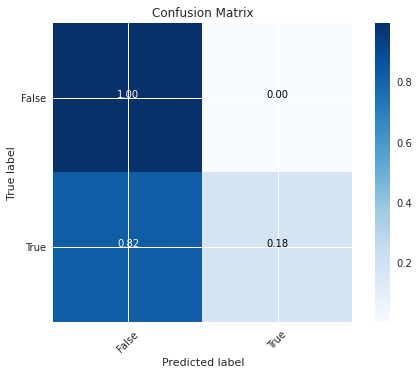

In [189]:
plot_confusion_matrix(rfc_matrix, classes=class_names, normalize=True)

## 2) K-Nearest Neighbor

In [190]:
knn = KNeighborsClassifier()
gs_knn = gridsearch_cv(knn, knn_params, X_train, y_train, kf)
predictions2 = gs_knn.predict(X_test)

In [191]:
print('Accuracy Score', accuracy_score(y_test, predictions2))
print('Recall Score', recall_score(y_test, predictions2))
print('F1 Score', f1_score(y_test, predictions2))
print('AUC', roc_auc_score(y_test, predictions2))

Accuracy Score 0.926829268292683
Recall Score 0.29411764705882354
F1 Score 0.35714285714285715
AUC 0.6339583868481891


In [192]:
knn_matrix = confusion_matrix(y_test, predictions2)
print('K-Nearest Neighbor Confusion Matrix: \n', knn_matrix)

K-Nearest Neighbor Confusion Matrix: 
 [[223   6]
 [ 12   5]]


Normalized confusion matrix


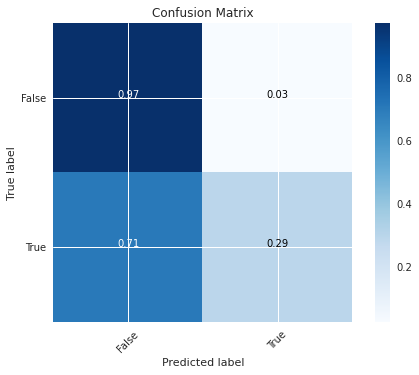

In [193]:
plot_confusion_matrix(knn_matrix, classes=class_names, normalize=True)

## 3) Decision Tree

In [194]:
dtc = DecisionTreeClassifier()
gs_dtc = gridsearch_cv(dtc, decision_tree_params, X_train, y_train, kf)
predictions3 = gs_dtc.predict(X_test)

In [195]:
print('Accuracy Score', accuracy_score(y_test, predictions3))
print('Recall Score', recall_score(y_test, predictions3))
print('F1 Score', f1_score(y_test, predictions3))
print('AUC', roc_auc_score(y_test, predictions3))

Accuracy Score 0.9186991869918699
Recall Score 0.17647058823529413
F1 Score 0.23076923076923078
AUC 0.5751348574364245


In [196]:
dtc_matrix = confusion_matrix(y_test, predictions3)
print('Decistion Tree Confusion Matrix: \n', dtc_matrix)

Decistion Tree Confusion Matrix: 
 [[223   6]
 [ 14   3]]


Normalized confusion matrix


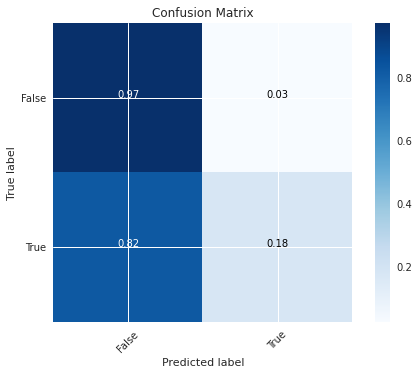

In [197]:
plot_confusion_matrix(dtc_matrix, classes=class_names, normalize=True)

## 4)XGBoost

In [198]:
xgboost = XGBClassifier()
gs_xgb = gridsearch_cv(xgboost, xgb_params, X_train, y_train, kf)
predictions4 = gs_xgb.predict(X_test)

In [199]:
print('Accuracy Score', accuracy_score(y_test, predictions4))
print('Recall Score', recall_score(y_test, predictions4))
print('F1 Score', f1_score(y_test, predictions4))
print('AUC', roc_auc_score(y_test, predictions4))

Accuracy Score 0.8983739837398373
Recall Score 0.0
F1 Score 0.0
AUC 0.48253275109170307


In [200]:
xgb_matrix = confusion_matrix(y_test, predictions4)
print('XGBoost Confusion Matrix: \n', xgb_matrix)

XGBoost Confusion Matrix: 
 [[221   8]
 [ 17   0]]


Normalized confusion matrix


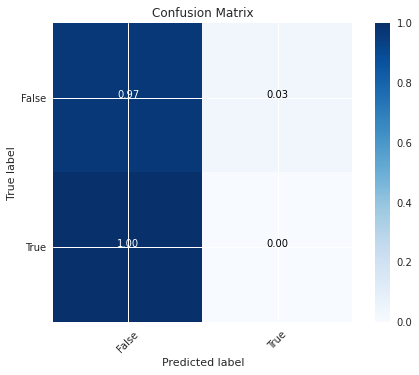

In [201]:
plot_confusion_matrix(xgb_matrix, classes=class_names, normalize=True)

## 5) MLP Classifier

In [202]:
mlp = MLPClassifier()
gs_mlp = gridsearch_cv(mlp, mlp_params, X_train, y_train, cv=5)
predictions5 = gs_mlp.predict(X_test)

In [203]:
print('Accuracy Score', accuracy_score(y_test, predictions5))
print('Recall Score', recall_score(y_test, predictions5))
print('F1 Score', f1_score(y_test, predictions5))
print('AUC', roc_auc_score(y_test, predictions5))

Accuracy Score 0.8983739837398373
Recall Score 0.47058823529411764
F1 Score 0.39024390243902435
AUC 0.700359619830465


In [204]:
mlp_matrix = confusion_matrix(y_test, predictions5)
print('Decistion Tree Confusion Matrix: \n', mlp_matrix)

Decistion Tree Confusion Matrix: 
 [[213  16]
 [  9   8]]


Normalized confusion matrix


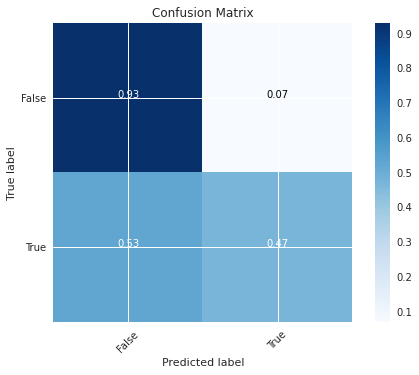

In [205]:
plot_confusion_matrix(mlp_matrix, classes=class_names, normalize=True)

### Plot Receiver Operating Characteristic (ROC) Curve

The ROC curve (Receiver Operating Characteristics curve) is the display of sensitivity and specificity for different cut-off values for probability (If the probability of positive response is above the cut-off, we predict a positive outcome, if not we are predicting a negative one). Each cut-off value defines one point on ROC curve, ranging cut-off from 0 to 1 will draw the whole ROC curve.

In short, ROC curve tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, the higher the AUC, better the model is at distinguishing between churned customers and non-churned customers.

ROC Curve is generated by plotting the True Positive rate (y-axis) against the False Positive rate (x-axis).

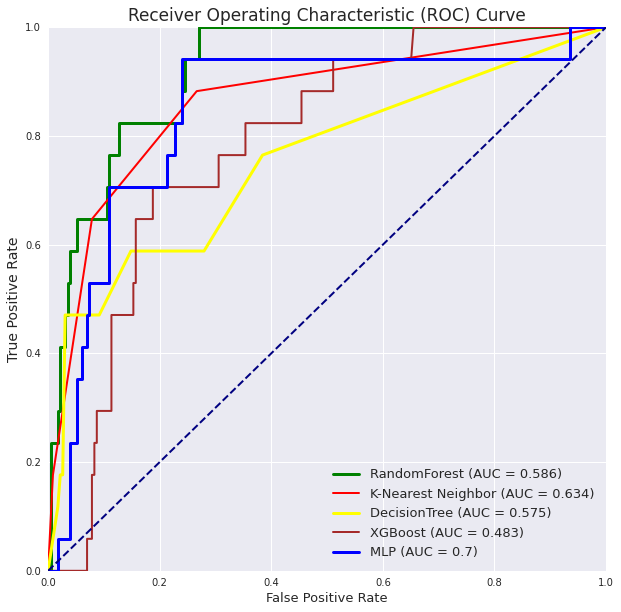

In [206]:
plt.figure(figsize=(10,10))

y_pred = gs_rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='green',
         lw=3, label='RandomForest (AUC = {})'.format(round(roc_auc_score(y_test, predictions), 3)))

y_pred = gs_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red',
         lw=2, label='K-Nearest Neighbor (AUC = {})'.format(round(roc_auc_score(y_test, predictions2), 3)))

y_pred = gs_dtc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='yellow',
         lw=3, label='DecisionTree (AUC = {})'.format(round(roc_auc_score(y_test, predictions3), 3)))

y_pred = gs_xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='brown',
         lw=2, label='XGBoost (AUC = {})'.format(round(roc_auc_score(y_test, predictions4), 3)))

y_pred = gs_mlp.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='blue',
         lw=3, label='MLP (AUC = {})'.format(round(roc_auc_score(y_test, predictions5), 3)))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

Plot the ROC curve with only top 3 models: MLP, KNN, and Random Forest

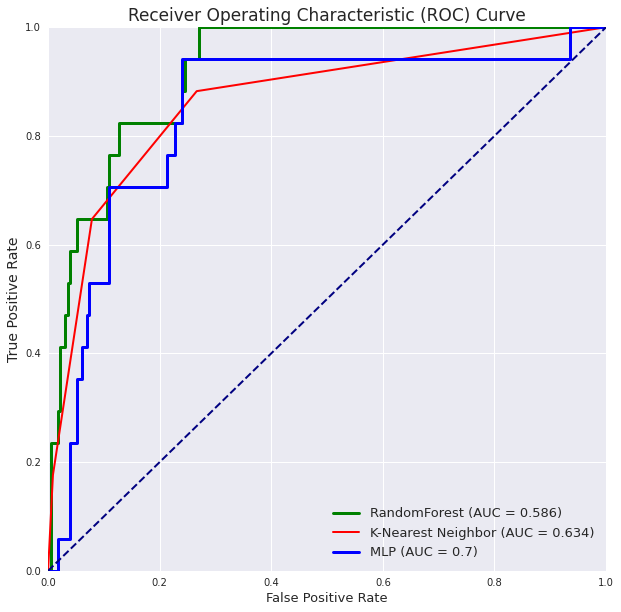

In [207]:
# Plot ROC curve again with only top 3 models
plt.figure(figsize=(10,10))

y_pred = gs_rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='green',
         lw=3, label='RandomForest (AUC = {})'.format(round(roc_auc_score(y_test, predictions), 3)))

y_pred = gs_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red',
         lw=2, label='K-Nearest Neighbor (AUC = {})'.format(round(roc_auc_score(y_test, predictions2), 3)))

y_pred = gs_mlp.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='blue',
         lw=3, label='MLP (AUC = {})'.format(round(roc_auc_score(y_test, predictions5), 3)))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

### Calculate metrics on test sets of each classifier

* Accuracy: How often is the classifier correct?

  Can be misleading with unbalanced datasets
* Precision: When it predicts yes, how often is it correct?

 Can be misleading if the model is very conservative about which cases they predict as true
* Recall: When it is actually yes, how often does it predict yes?

 Can get a 100% recall score by simply assuming every case is true, which would not necessarily be a better model
* F1: The harmonic average of precision and recall. 
 
 F1 cannot be high without both precision and recall being high. Therefore, in this case, F1 score is a great metric to choose which model is the best along with AUC.

In [208]:
classifiers = [gs_rfc, gs_knn, gs_dtc, gs_xgb, gs_mlp]
classifier_names = ['Random Forest', 'KNN', 'Decision Tree', 'XGBoost', 'Neural Network MLP']
auc_scores = [0.586051, 0.633958, 0.600179, 0.482532, 0.675314]

accs = []
recalls = []
precision = []
results_table = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

for (i, clf), name, auc in zip(enumerate(classifiers), classifier_names, auc_scores):
    y_pred = clf.predict(X_test)
    row = []
    row.append(accuracy_score(y_test, y_pred))
    row.append(precision_score(y_test, y_pred))
    row.append(recall_score(y_test, y_pred))
    row.append(f1_score(y_test, y_pred))
    row.append(auc)
    row = ["%.3f" % r for r in row]
    results_table.loc[name] = row

print(results_table)

                   Accuracy Precision Recall     F1    AUC
Random Forest         0.939     0.750  0.176  0.286  0.586
KNN                   0.927     0.455  0.294  0.357  0.634
Decision Tree         0.919     0.333  0.176  0.231  0.600
XGBoost               0.898     0.000  0.000  0.000  0.483
Neural Network MLP    0.898     0.333  0.471  0.390  0.675


#### Comment: MLP Classifier of Neural Network has the best performance, following by K-Nearest Neighbor and Random Forest

Text(0.5, 1.0, 'Top Features by Random Forest')

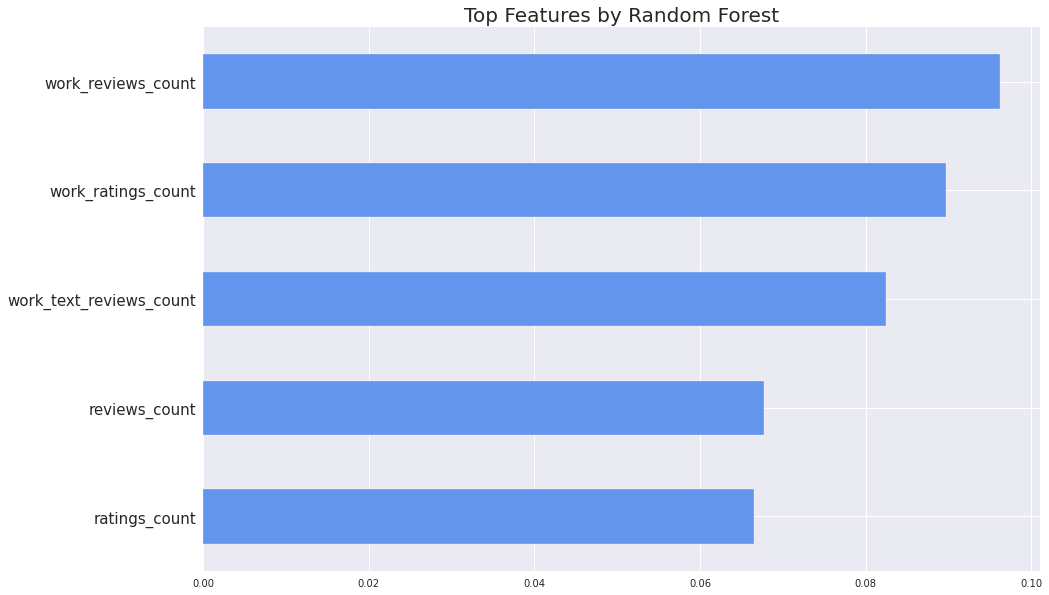

In [209]:
# Fit the model
rfc_model = rfc.fit(X, y)

# Plot the top features based on its importance
(pd.Series(rfc_model.feature_importances_, index=X.columns)
   .nlargest(5)   # can adjust based on how many top features you want
   .plot(kind='barh', figsize=[15,10], color='cornflowerblue')
   .invert_yaxis()) # Ensures that the feature with the most importance is on top, in descending order

plt.yticks(size=15)
plt.title('Top Features by Random Forest', size=20)

# Modeling for the Original Dataset (without additional features)

## Statsmodel's Ordinary Least Squares (OLS)

In [211]:
# Define features X and target y for the original dataset
y_2 = df2['popularity']
X_2 = df2.drop('popularity', axis=1)

# Define the intercept
X_2 = sm.add_constant(X_2)

# Fit a model
model_2 = sm.OLS(y_2, X_2)
result_2 = model_2.fit()

# Summarize results
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     1.316
Date:                Tue, 22 Sep 2020   Prob (F-statistic):           0.000343
Time:                        17:38:16   Log-Likelihood:                 286.48
No. Observations:                1226   AIC:                             573.0
Df Residuals:                     653   BIC:                             3502.
Df Model:                         572                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            0.0292      0.024      1.210      0.227      -0.018       0.077
dummy_Ace                                       -0.1015      0.234     -0.434      0.665      -0.561       0.358
dummy_Algonquin                                  0.4841      0.131      3.689      0.000       0.226       0.742
dummy_Anchor                                     0.3872      0.320      1.211      0.226      -0.241       1.015
dummy_Atlantic Monthly                          -0.0140      0.124     -0.113      0.910      -0.258       0.230
dummy_Atlantic Monthly Press                    -0.0089      0.180     -0.050      0.960      -0.363       0.345
dummy_Atria                                     -0.0389      0.182     -0.214      0.831      -0.396       0.318
dummy_Atria Books                               -0.1977      0.208     -0.949      0.343      -0.606       0.211
dummy_Atria/Emily Bestler                       -0.4893      0.238     -2.056      0.040      -0.957      -0.022
dummy_Atria/Keywords                            -0.0059      0.132     -0.045      0.964      -0.264       0.252
dummy_Avon                                      -0.0319      0.096     -0.331      0.741      -0.221       0.157
dummy_Avon Impulse                              -0.0297      0.180     -0.165      0.869      -0.383       0.324
dummy_Avon/HarperCollins                         0.0076      0.165      0.046      0.963      -0.317       0.332
dummy_Ballantine                                -0.0297      0.092     -0.324      0.746      -0.210       0.150
dummy_Ballatine                                  0.0203      0.294      0.069      0.945      -0.557       0.598
dummy_Bantam                                     0.0100      0.106      0.094      0.925      -0.198       0.218
dummy_Berkley                                   -0.1506      0.120     -1.259      0.208      -0.385       0.084
dummy_Bethany House                             -0.0109      0.131     -0.083      0.934      -0.269       0.247
dummy_Bloomsbury                                -0.0159      0.131     -0.121      0.903      -0.274       0.242
dummy_BookShots                                 -0.2481      0.287     -0.863      0.388      -0.813       0.316
dummy_Broadway                                   0.1829      0.118      1.546      0.122      -0.049       0.415
dummy_Carina                                     0.1498      0.330      0.454      0.650      -0.498       0.798
dummy_Carina Press                               0.1498      0.330      0.454      0.650      -0.498       0.798
dummy_Center Street                             -0.3948      0.299     -1.322      0.186      -0.981       0.191
dummy_Crown                     

## Train-Test Split the data

In [212]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [213]:
# Add appropriate axis scales
# Get class labels to add to matrix
class_names_2 = set(y_2)

## 1) Random Forest

In [214]:
rfc_2 = RandomForestClassifier(random_state=18)
gs_rfc_2 = gridsearch_cv(rfc_2, random_forest_params, X_train_2, y_train_2, kf)
ori_predictions = gs_rfc_2.predict(X_test_2)

In [215]:
print('Accuracy Score', accuracy_score(y_test_2, ori_predictions))
print('Recall Score', recall_score(y_test_2, ori_predictions))
print('F1 Score', f1_score(y_test_2, ori_predictions))
print('AUC', roc_auc_score(y_test_2, ori_predictions))

Accuracy Score 0.9227642276422764
Recall Score 0.058823529411764705
F1 Score 0.09523809523809523
AUC 0.5228615463652709


In [216]:
rfc_matrix_2 = confusion_matrix(y_test_2, ori_predictions)
print('Random Forest Classifier Confusion Matrix: \n', rfc_matrix_2)

Random Forest Classifier Confusion Matrix: 
 [[226   3]
 [ 16   1]]


Normalized confusion matrix


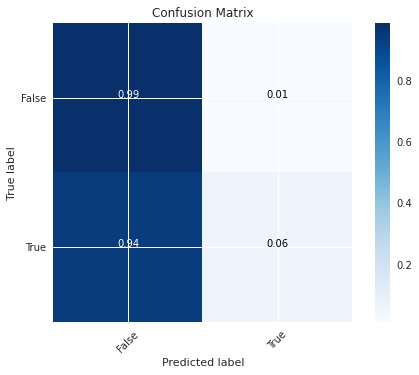

In [217]:
plot_confusion_matrix(rfc_matrix_2, classes=class_names_2, normalize=True)

## 2) K-Nearest Neighbor

In [218]:
knn = KNeighborsClassifier()
gs_knn_2 = gridsearch_cv(knn, knn_params, X_train_2, y_train_2, kf)
ori_predictions2 = gs_knn_2.predict(X_test_2)

In [219]:
print('Accuracy Score', accuracy_score(y_test_2, ori_predictions2))
print('Recall Score', recall_score(y_test_2, ori_predictions2))
print('F1 Score', f1_score(y_test_2, ori_predictions2))
print('AUC', roc_auc_score(y_test_2, ori_predictions2))

Accuracy Score 0.9227642276422764
Recall Score 0.11764705882352941
F1 Score 0.1739130434782609
AUC 0.5500899049576162


In [220]:
knn_matrix_2 = confusion_matrix(y_test_2, ori_predictions2)
print('K-Nearest Neighbor Confusion Matrix: \n', knn_matrix_2)

K-Nearest Neighbor Confusion Matrix: 
 [[225   4]
 [ 15   2]]


Normalized confusion matrix


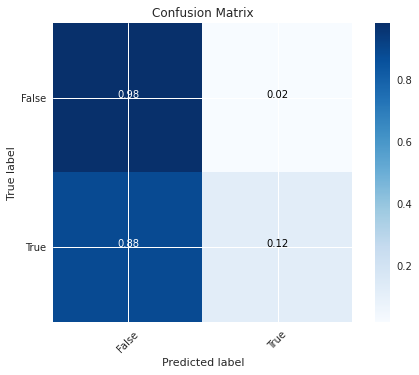

In [221]:
plot_confusion_matrix(knn_matrix_2, classes=class_names_2, normalize=True)

## 3) Decision Tree

In [222]:
dtc = DecisionTreeClassifier()
gs_dtc_2 = gridsearch_cv(dtc, decision_tree_params, X_train_2, y_train_2, kf)
ori_predictions3 = gs_dtc_2.predict(X_test_2)

In [223]:
print('Accuracy Score', accuracy_score(y_test_2, ori_predictions3))
print('Recall Score', recall_score(y_test_2, ori_predictions3))
print('F1 Score', f1_score(y_test_2, ori_predictions3))
print('AUC', roc_auc_score(y_test_2, ori_predictions3))

Accuracy Score 0.9349593495934959
Recall Score 0.11764705882352941
F1 Score 0.2
AUC 0.5566401232982277


In [224]:
dtc_matrix_2 = confusion_matrix(y_test_2, ori_predictions3)
print('Decistion Tree Confusion Matrix: \n', dtc_matrix_2)

Decistion Tree Confusion Matrix: 
 [[228   1]
 [ 15   2]]


Normalized confusion matrix


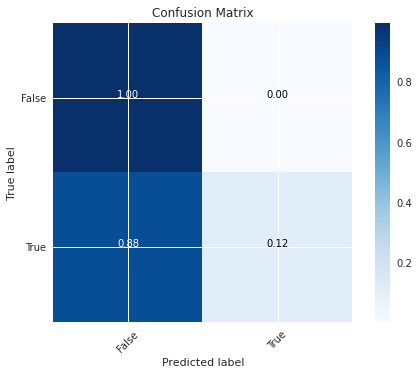

In [225]:
plot_confusion_matrix(dtc_matrix_2, classes=class_names_2, normalize=True)

## 4)XGBoost

In [226]:
xgboost = XGBClassifier()
gs_xgb_2 = gridsearch_cv(xgboost, xgb_params, X_train_2, y_train_2, kf)
ori_predictions4 = gs_xgb_2.predict(X_test_2)

In [ ]:
print('Accuracy Score', accuracy_score(y_test_2, ori_predictions4))
print('Recall Score', recall_score(y_test_2, ori_predictions4))
print('F1 Score', f1_score(y_test_2, ori_predictions4))
print('AUC', roc_auc_score(y_test_2, ori_predictions4))

Accuracy Score 0.8983739837398373
Recall Score 0.0
F1 Score 0.0
AUC 0.48253275109170307


In [227]:
xgb_matrix_2 = confusion_matrix(y_test_2, ori_predictions4)
print('XGBoost Confusion Matrix: \n', xgb_matrix_2)

XGBoost Confusion Matrix: 
 [[229   0]
 [ 17   0]]


Normalized confusion matrix


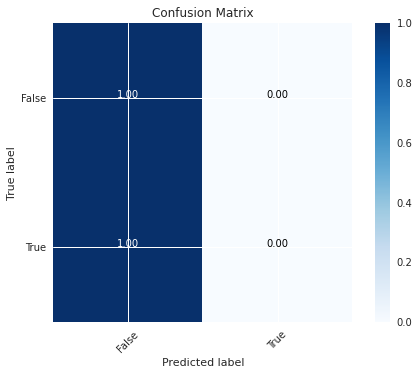

In [228]:
plot_confusion_matrix(xgb_matrix_2, classes=class_names_2, normalize=True)

## 5) MLP Classifier

In [229]:
mlp = MLPClassifier()
gs_mlp_2 = gridsearch_cv(mlp, mlp_params, X_train_2, y_train_2, cv=5)
ori_predictions5 = gs_mlp_2.predict(X_test_2)

In [230]:
print('Accuracy Score', accuracy_score(y_test_2, ori_predictions5))
print('Recall Score', recall_score(y_test_2, ori_predictions5))
print('F1 Score', f1_score(y_test_2, ori_predictions5))
print('AUC', roc_auc_score(y_test_2, ori_predictions5))

Accuracy Score 0.9024390243902439
Recall Score 0.17647058823529413
F1 Score 0.20000000000000004
AUC 0.5664012329822758


In [231]:
mlp_matrix_2 = confusion_matrix(y_test_2, ori_predictions5)
print('Decistion Tree Confusion Matrix: \n', mlp_matrix_2)

Decistion Tree Confusion Matrix: 
 [[219  10]
 [ 14   3]]


Normalized confusion matrix


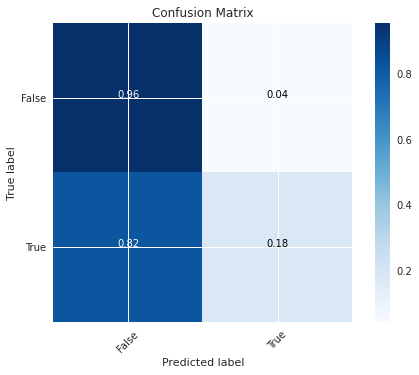

In [232]:
plot_confusion_matrix(mlp_matrix_2, classes=class_names_2, normalize=True)

### Plot Receiver Operating Characteristic (ROC) Curve

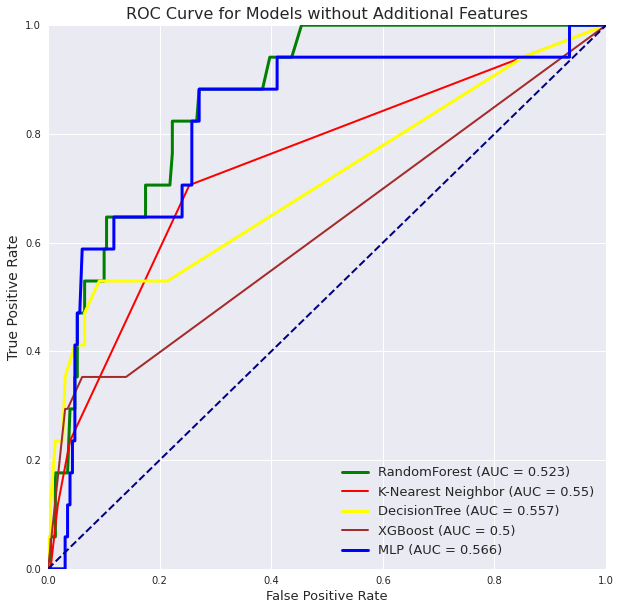

In [233]:
plt.figure(figsize=(10,10))

y_pred_2 = gs_rfc_2.predict_proba(X_test_2)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_2)
plt.plot(fpr, tpr, color='green',
         lw=3, label='RandomForest (AUC = {})'.format(round(roc_auc_score(y_test_2, ori_predictions), 3)))

y_pred_2 = gs_knn_2.predict_proba(X_test_2)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_2)
plt.plot(fpr, tpr, color='red',
         lw=2, label='K-Nearest Neighbor (AUC = {})'.format(round(roc_auc_score(y_test_2, ori_predictions2), 3)))

y_pred_2 = gs_dtc_2.predict_proba(X_test_2)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_2)
plt.plot(fpr, tpr, color='yellow',
         lw=3, label='DecisionTree (AUC = {})'.format(round(roc_auc_score(y_test_2, ori_predictions3), 3)))

y_pred_2 = gs_xgb_2.predict_proba(X_test_2)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_2)
plt.plot(fpr, tpr, color='brown',
         lw=2, label='XGBoost (AUC = {})'.format(round(roc_auc_score(y_test_2, ori_predictions4), 3)))

y_pred_2 = gs_mlp_2.predict_proba(X_test_2)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_2)
plt.plot(fpr, tpr, color='blue',
         lw=3, label='MLP (AUC = {})'.format(round(roc_auc_score(y_test_2, ori_predictions5), 3)))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Models without Additional Features', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.show()

Plot the ROC curve with only top 3 models: MLP, DecisionTree, and KNN

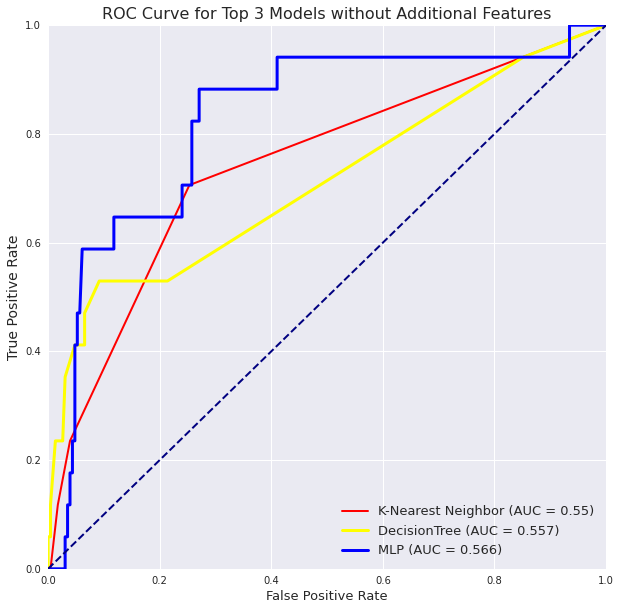

In [234]:
# Plot ROC curve again with only top 3 models
plt.figure(figsize=(10,10))

y_pred_2 = gs_knn_2.predict_proba(X_test_2)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_2)
plt.plot(fpr, tpr, color='red',
         lw=2, label='K-Nearest Neighbor (AUC = {})'.format(round(roc_auc_score(y_test_2, ori_predictions2), 3)))

y_pred_2 = gs_dtc_2.predict_proba(X_test_2)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_2)
plt.plot(fpr, tpr, color='yellow',
         lw=3, label='DecisionTree (AUC = {})'.format(round(roc_auc_score(y_test_2, ori_predictions3), 3)))

y_pred_2 = gs_mlp_2.predict_proba(X_test_2)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_2)
plt.plot(fpr, tpr, color='blue',
         lw=3, label='MLP (AUC = {})'.format(round(roc_auc_score(y_test_2, ori_predictions5), 3)))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Top 3 Models without Additional Features', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.show()

### Calculate metrics on test sets of each classifier

In [235]:
classifiers = [gs_rfc_2, gs_knn_2, gs_dtc_2, gs_xgb_2, gs_mlp_2]
classifier_names = ['Random Forest 2', 'KNN 2', 'Decision Tree 2', 'XGBoost 2', 'Neural Network MLP 2']
auc_scores = [0.522861, 0.550089, 0.556640, 0.482532, 0.566401]

accs = []
recalls = []
precision = []
results_table = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

for (i, clf), name, auc in zip(enumerate(classifiers), classifier_names, auc_scores):
    y_pred_2 = clf.predict(X_test_2)
    row = []
    row.append(accuracy_score(y_test_2, y_pred_2))
    row.append(precision_score(y_test_2, y_pred_2))
    row.append(recall_score(y_test_2, y_pred_2))
    row.append(f1_score(y_test_2, y_pred_2))
    row.append(auc)
    row = ["%.3f" % r for r in row]
    results_table.loc[name] = row

print(results_table)

                     Accuracy Precision Recall     F1    AUC
Random Forest 2         0.923     0.250  0.059  0.095  0.523
KNN 2                   0.923     0.333  0.118  0.174  0.550
Decision Tree 2         0.935     0.667  0.118  0.200  0.557
XGBoost 2               0.931     0.000  0.000  0.000  0.483
Neural Network MLP 2    0.902     0.231  0.176  0.200  0.566
